In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from covpred import *
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
%matplotlib inline

In [29]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').replace('0. ', '0 ').replace('1. ', '1 ').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

def get_idx(column):
    return np.where(df.columns == column)[0][0]

In [30]:
np.random.seed(5)
names = ["state", "county", "community", "communityname", "fold", "population", "householdsize", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par", "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell", "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant", "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ", "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState", "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens", "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"]
df = pd.read_csv("data/crime_data.csv", names=names)
df[df == "?"] = np.nan
df.drop(["communityname", "state", "fold"], axis=1, inplace=True)
df = df.loc[:,~df.isna().any(axis=0)]
df.head().T

idx_predict = [get_idx(c) for c in ["agePct65up", "pctWSocSec"]]
idx_use = np.setdiff1d(np.arange(df.shape[1]), idx_predict)

X = df.iloc[:,idx_use]
Y = df.iloc[:,idx_predict]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y)
Xtrain.shape, Xtest.shape

/home/shane/miniconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


((1495, 98), (499, 98))

In [31]:
qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
Ytrain = qt.fit_transform(Ytrain)
Ytest = qt.transform(Ytest)
qt = QuantileTransformer(n_quantiles=100)
Xtrain = qt.fit_transform(Xtrain)
Xtest = qt.fit_transform(Xtest)
Xtrain = (Xtrain - .5) * 2
Xtest = (Xtest - .5) * 2

In [32]:
lr = RidgeCV(alphas=np.logspace(-3,3,100))
lr.fit(Xtrain, Ytrain)
np.mean(np.square(lr.predict(Xtrain) - Ytrain)), np.mean(np.square(lr.predict(Xtest) - Ytest))

(0.1239501458548298, 0.12886895276118335)

In [33]:
X_cov_train = Xtrain
X_cov_test = Xtest
Y_cov_train = lr.predict(Xtrain) - Ytrain
Y_cov_test = lr.predict(Xtest) - Ytest

In [34]:
print(bmatrix(np.round(np.cov(Y_cov_train.T), 2)))

\begin{bmatrix}
  0.14 & 0.08\\
  0.08 & 0.11\\
\end{bmatrix}


In [35]:
whitener0 = ConstantWhitener()
whitener0.fit(Y_cov_train)
Sigma0, _, _, _ = whitener0.whiten(Y_cov_test)
print("Constant & %.2f & %.2f \\\\" % (whitener0.score(Y_cov_train), whitener0.score(Y_cov_test)))

whitener1 = DiagonalWhitener(lam=.1)
whitener1.fit(Y_cov_train, X_cov_train)
Sigma1, _, _, _ = whitener1.whiten(Y_cov_test, X_cov_test)
print("Diagonal & %.2f & %.2f \\\\" % (whitener1.score(Y_cov_train, X_cov_train), whitener1.score(Y_cov_test, X_cov_test)))

whitener2 = RegressionWhitener(epsilon=1e-2, lam_1=0.1, lam_2=0)
whitener2.fit(Y_cov_train, X_cov_train)
Sigma2, _, _, _ = whitener2.whiten(Y_cov_test, X_cov_test)
print("Regression & %.2f & %.2f \\\\" % (whitener2.score(Y_cov_train, X_cov_train), whitener2.score(Y_cov_test, X_cov_test)))

whitener3 = IteratedWhitener([
    ConstantWhitener(),
    DiagonalWhitener(lam=.1)
])
whitener3.fit(Y_cov_train, X_cov_train)
Sigma3, _, _, _ = whitener3.whiten(Y_cov_test, X_cov_test)
print("Constant, then diagonal & %.2f & %.2f \\\\" % (whitener3.score(Y_cov_train, X_cov_train), whitener3.score(Y_cov_test, X_cov_test)))

whitener4 = IteratedWhitener([
    DiagonalWhitener(lam=.1),
    ConstantWhitener()
])
whitener4.fit(Y_cov_train, X_cov_train)
Sigma4, _, _, _ = whitener4.whiten(Y_cov_test, X_cov_test)
print("Diagonal, then constant & %.2f & %.2f \\\\" % (whitener4.score(Y_cov_train, X_cov_train), whitener4.score(Y_cov_test, X_cov_test)))

whitener5 = IteratedWhitener([
    ConstantWhitener(),
    RegressionWhitener(epsilon=1e-2, lam_1=1, lam_2=1)
])
whitener5.fit(Y_cov_train, X_cov_train)
Sigma5, _, _, _ = whitener5.whiten(Y_cov_test, X_cov_test)
print("Constant, then regression & %.2f & %.2f \\\\" % (whitener5.score(Y_cov_train, X_cov_train), whitener5.score(Y_cov_test, X_cov_test)))

whitener6 = IteratedWhitener([
    RegressionWhitener(epsilon=1e-2, lam_1=.01, lam_2=0),
    ConstantWhitener()
])
whitener6.fit(Y_cov_train,X_cov_train)
Sigma6, _, _, _ = whitener6.whiten(Y_cov_test, X_cov_test)
print("Regression, then constant & %.2f & %.2f \\\\" % (whitener6.score(Y_cov_train, X_cov_train), whitener6.score(Y_cov_test, X_cov_test)))

# whitener7 = IteratedWhitener([
#     DiagonalWhitener(lam=.1),
#     RegressionWhitener(epsilon=1e-3, lam_1=1, lam_2=0),
#     ConstantWhitener(),
# ])
# whitener7.fit(Y_cov_train,X_cov_train)
# Sigma7, _, _, _ = whitener7.whiten(Y_cov_test, X_cov_test)
# print("Diagonal, then full, then constant & %.2f & %.2f \\\\" % (whitener7.score(Y_cov_train, X_cov_train), whitener7.score(Y_cov_test, X_cov_test)))

Constant & -0.47 & -0.44 \\
Diagonal & -0.37 & -0.55 \\
Regression & -0.05 & -0.14 \\
Constant, then diagonal & -0.45 & -0.69 \\
Diagonal, then constant & 0.00 & -0.18 \\
Constant, then regression & -0.26 & -0.33 \\
Regression, then constant & 0.01 & -0.11 \\


In [36]:
# plt.hist(np.linalg.norm(whitener0.whiten(Y_cov_test)[2], axis=1)**2, bins=50, alpha=.5);
# plt.hist(np.linalg.norm(whitener2.whiten(Y_cov_test, X_cov_test)[2], axis=1)**2, bins=50, alpha=.5);

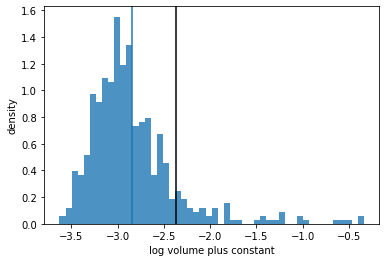

In [37]:
Sigmas = whitener6.whiten(Y_cov_test, X_cov_test)[0]
Corrs = [Sigmas[i] / np.sqrt(np.outer(np.diag(Sigmas[i]), np.diag(Sigmas[i]))) for i in range(Sigmas.shape[0])]
log_vols = [.5 * np.linalg.slogdet(S)[1] for S in Sigmas]
plt.hist(np.array(log_vols), bins=50, density=True, alpha=.8)
plt.axvline(np.mean(log_vols))
plt.axvline(.5 * np.linalg.slogdet(whitener0.Sigma)[1], c='black')
plt.xlabel("log volume plus constant")
plt.ylabel("density")
plt.savefig("figs/log_volume.pdf")

In [38]:
np.exp(np.mean(log_vols) - .5 * np.linalg.slogdet(whitener0.Sigma)[1])

0.6177449834421579

In [39]:
X = np.array(Corrs).min(axis=0)
Y = np.array(Corrs).max(axis=0)
print("(" + ", ".join([str(s) for s in np.round(np.sqrt(np.diag(Sigmas.min(axis=0))), 2)]) + ")")
print("(" + ", ".join([str(s) for s in np.round(np.sqrt(np.diag(Sigmas.max(axis=0))), 2)]) + ")")
print(bmatrix(np.round(X, 3)))
print(bmatrix(np.round(Y, 3)))

(0.19, 0.18)
(1.16, 0.88)
\begin{bmatrix}
  1 & -0.045\\
  -0.045 & 1\\
\end{bmatrix}
\begin{bmatrix}
  1 & 0.908\\
  0.908 & 1\\
\end{bmatrix}


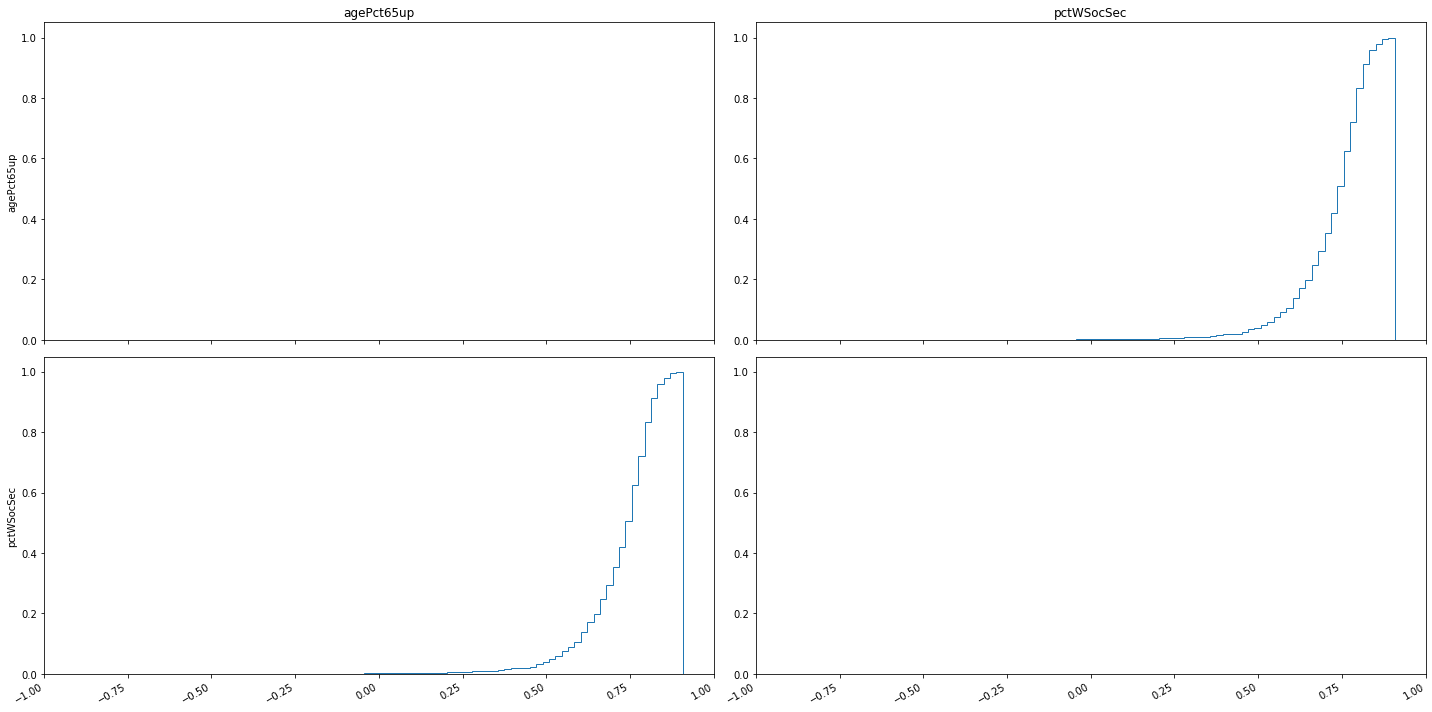

In [40]:
n = len(idx_predict)
fig, axes = plt.subplots(n, n, figsize=(20, 10))
fig.autofmt_xdate()
for i in range(n):
    for j in range(n):
        axes[i,j].hist(np.array(Corrs)[:,i,j], bins=50, cumulative=True, density=True, histtype='step')
        axes[i,j].set_xlim(-1,1)

for i, col1 in enumerate(df.columns[idx_predict]):
    axes[i,0].set_ylabel(col1)
for j, col2 in enumerate(df.columns[idx_predict]):
    axes[0,j].set_title(col2)

plt.tight_layout()
plt.show()

In [41]:
# for i in range(n):
#     plt.hist(np.sqrt(np.array(Sigmas)[:,i,i]), bins=50, cumulative=True, density=True, histtype='step')
#     plt.show()

[-0.07625419 -0.24594584]


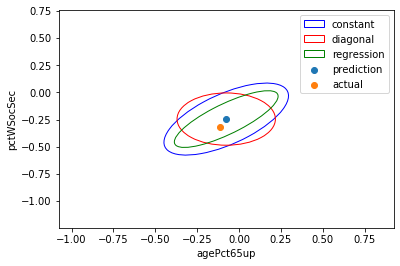

In [42]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
j = 1
def plot_ellipse(ax, Sigma, xy, c='k'):
    lambda_, v = np.linalg.eig(Sigma[-2:,-2:])
    lambda_ = np.sqrt(lambda_)
    ell = Ellipse(xy=xy,
                  width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])), alpha=1, ec=c, fc='none')
    ax.add_artist(ell)
    return ell
i = 30
xy = lr.predict(Xtest)[i,-2:]
print(xy)
fig, ax = plt.subplots()
ell1 = plot_ellipse(ax, Sigma0[i], xy=xy, c='b')
ell2 = plot_ellipse(ax, Sigma1[i], xy=xy, c='r')
ell3 = plot_ellipse(ax, Sigma6[i], xy=xy, c='g')
plt.xlim(xy[0] - 1, xy[0] + 1)
plt.ylim(xy[1] - 1, xy[1] + 1)
scat1 = plt.scatter([xy[0]], [xy[1]])
scat2 = plt.scatter([Ytest[i,-2]], [Ytest[i,-1]])
ax.legend([ell1, ell2, ell3, scat1, scat2], ['constant', 'diagonal', 'regression', 'prediction', 'actual'])
plt.xlabel(df.columns[idx_predict][-2])
plt.ylabel(df.columns[idx_predict][-1])
plt.savefig("figs/confidence_ellipse.pdf")
plt.show()

In [43]:
lr.predict(X_cov_test)[-1]

array([-1.87370507, -1.9235837 ])

In [44]:
np.exp(-.5 * np.linalg.slogdet(Sigma0[i][-2:,-2:])[1] + .5 * np.linalg.slogdet(Sigma6[i][-2:,-2:])[1])

0.5105206461300669

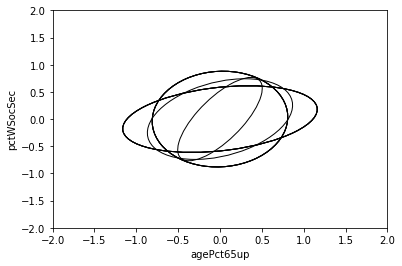

In [45]:
fig, ax = plt.subplots()
for e in np.linspace(0, np.pi, 10):
    x = np.array([np.cos(e), np.sin(e)])
    plot_ellipse(ax, Sigma6[np.argmin([x @ np.linalg.solve(S, x) for S in Sigma6])], np.zeros(2))
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel(df.columns[idx_predict][-2])
plt.ylabel(df.columns[idx_predict][-1])
plt.savefig("figs/confidence_ellipse_extremes.pdf")
plt.show()

## Joint mean-covariance prediction

In [46]:
from scipy.linalg import solve_triangular
from sklearn.linear_model import LinearRegression

In [47]:
def fit(X, Y, epsilon=1e-3, lam_1=0, lam_2=0, lam_3=0):
    T, p = X.shape
    T, n = Y.shape
    diag_rows, diag_cols = np.diag_indices(n)
    off_diag_cols, off_diag_rows = np.triu_indices(n, k=1)
    k = off_diag_rows.size
    def f(x):
        Aplus = x[:n*p].reshape(n, p)
        Aneg = x[n*p:n*p*2].reshape(n, p)
        bplus = x[n*p*2:n*(p*2+1)]
        C = x[n*(p*2+1):n*(p*2+1)+k*p].reshape(k, p)
        d = x[n*(p*2+1)+k*p:n*(p*2+1)+k*p+k]
        A = Aplus - Aneg
        b = (Aplus + Aneg) @ np.ones(p) + epsilon + bplus
        Areg = x[n*(p*2+1)+k*p+k:n*(p*2+1)+k*p+k+p*n].reshape(n, p)
        breg = x[n*(p*2+1)+k*p+k+p*n:n*(p*2+1)+k*p+k+p*n+n]

        pred = X @ Areg.T + breg

        L = np.zeros((T, n, n))

        L[:, diag_rows, diag_cols] = X @ A.T + b
        L[:, off_diag_rows, off_diag_cols] = X @ C.T + d

        f = -np.log(L[:, diag_rows, diag_cols]).sum() / T + \
            .5 * np.square((Y[:,:,None] * L).sum(axis=1) - pred).sum() / T + \
            lam_1 / 2 * (np.sum(np.square(A)) + np.sum(np.square(C))) + \
            lam_2 / 2 * (np.sum(np.square(b - 1)) + np.sum(np.square(d))) + \
            lam_3 / 2 * np.sum(np.square(Areg))

        L_grad = np.zeros((T, n, n))
        L_grad[:, diag_rows, diag_cols] = -1.0 / L[:, diag_rows, diag_cols]
        L_grad += Y[:,:,None] * (L.transpose(0,2,1) * Y[:,None,:]).sum(axis=2)[:,None,:]
        L_grad -= Y[:,:,None] * pred[:,None,:]

        pred_grad = -(Y[:,:,None] * L).sum(axis=1) + pred

        Aplus_grad = (L_grad[:, diag_rows, diag_cols][:,:,None] * (X[:,None,:] + 1)).sum(axis=0) / T + \
                lam_1 * A + lam_2 * np.outer(b - 1, np.ones(p))
        Aneg_grad = (L_grad[:, diag_rows, diag_cols][:,:,None] * (-X[:,None,:] + 1)).sum(axis=0) / T - \
                lam_1 * A + lam_2 * np.outer(b - 1, np.ones(p))
        C_grad = (L_grad[:, off_diag_rows, off_diag_cols][:,:,None] * X[:,None,:]).sum(axis=0) / T + lam_1 * C

        bplus_grad = L_grad[:, diag_rows, diag_cols].sum(axis=0) / T + lam_2 * (b - 1)
        d_grad = L_grad[:, off_diag_rows, off_diag_cols].sum(axis=0) / T + lam_2 * d

        Areg_grad = pred_grad.T @ X / T + lam_3 * Areg
        breg_grad = pred_grad.sum(axis=0) / T

        grad = np.concatenate([
            Aplus_grad.flatten(),
            Aneg_grad.flatten(),
            bplus_grad.flatten(),
            C_grad.flatten(),
            d_grad.flatten(),
            Areg_grad.flatten(),
            breg_grad.flatten()
        ])
        return f, grad
    bounds = [(0, np.inf)] * (n*p) + [(0,np.inf)] * (n*p) + \
            [(0, np.inf)] * n + [(-np.inf, np.inf)] * k * p + [(-np.inf, np.inf)] * k + \
            [(-np.inf, np.inf)] * p * n + [(-np.inf, np.inf)] * n
    x = np.zeros(len(bounds))
    x[2*n*p:2*n*p+n] = 1 - epsilon
    x, fstar, info = fmin_l_bfgs_b(f, x, bounds=bounds)
    Aplus = x[:n*p].reshape(n, p)
    Aneg = x[n*p:n*p*2].reshape(n, p)
    bplus = x[n*p*2:n*(p*2+1)]
    C = x[n*(p*2+1):n*(p*2+1)+k*p].reshape(k, p)
    d = x[n*(p*2+1)+k*p:n*(p*2+1)+k*p+k]
    A = Aplus - Aneg
    b = (Aplus + Aneg) @ np.ones(p) + epsilon + bplus
    Areg = x[n*(p*2+1)+k*p+k:n*(p*2+1)+k*p+k+p*n].reshape(n, p)
    breg = x[n*(p*2+1)+k*p+k+p*n:n*(p*2+1)+k*p+k+p*n+n]
    
    return A, b, C, d, Areg, breg

In [48]:
def score(means, Sigmas, Y):
    score = 0.
    for i in range(means.shape[0]):
        score += -n*np.log(2*np.pi) - np.linalg.slogdet(Sigmas[i])[1] - .5 * (Y[i] - means[i]) @ np.linalg.solve(Sigmas[i], Y[i] - means[i])
    return score / means.shape[0]

In [49]:
def predict(X, A, b, C, d, Areg, breg):
    N = X.shape[0]
    nu = X @ Areg.T + breg
    diag_rows, diag_cols = np.diag_indices(n)
    off_diag_cols, off_diag_rows = np.triu_indices(n, k=1)
    k = off_diag_rows.size
    L = np.zeros((N, n, n))
    L[:, diag_rows, diag_cols] = X @ A.T + b
    L[:, off_diag_rows, off_diag_cols] = X @ C.T + d
    
    yhat = np.array([solve_triangular(L[i].T, nu[i]) for i in range(N)])
    return yhat, [np.linalg.inv(L[i] @ L[i].T) for i in range(N)]

In [50]:
A, b, C, d, Areg, breg = fit(Xtrain, Ytrain, epsilon=1e-8, lam_1=.01, lam_2=0, lam_3=0)

In [51]:
np.random.seed(0)
lr = RidgeCV(alphas=np.logspace(-3,3,100))
lr.fit(Xtrain, Ytrain);

In [52]:
def rmse(x):
    return np.sqrt(np.mean(np.square(x)))

In [53]:
mean_train = lr.predict(Xtrain)
res_train = mean_train - Ytrain
Sigmas_train = [np.cov(res_train.T)] * Ytrain.shape[0]
means_train = mean_train
mean_test = lr.predict(Xtest)
Sigmas_test = [np.cov(res_train.T)] * Ytest.shape[0]
res_test = mean_test - Ytest
round(rmse(res_train), 3), round(rmse(res_test), 3), round(score(mean_train, Sigmas_train, Ytrain), 3), round(score(mean_test, Sigmas_test, Ytest), 3)

(0.352, 0.359, 0.054, 0.088)

In [54]:
means_train, Sigmas_train = predict(Xtrain, A, b, C, d, Areg, breg)
means_test, Sigmas_test = predict(Xtest, A, b, C, d, Areg, breg)
res_train = means_train - Ytrain
res_test = means_test - Ytest
round(rmse(res_train), 3), round(rmse(res_test), 3), round(score(mean_train, Sigmas_train, Ytrain), 3), round(score(mean_test, Sigmas_test, Ytest), 3)

(0.273, 0.331, 1.132, 1.049)

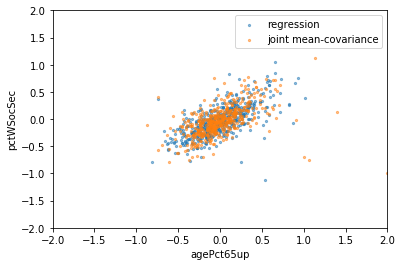

In [55]:
plt.scatter((lr.predict(Xtest) - Ytest)[:,0], (lr.predict(Xtest) - Ytest)[:,1], s=5, alpha=.5, label='regression')
plt.scatter((predict(Xtest, A, b, C, d, Areg, breg)[0] - Ytest)[:,0], (predict(Xtest, A, b, C, d, Areg, breg)[0] - Ytest)[:,1], s=5, alpha=.5, label='joint mean-covariance')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.xlabel(df.columns[idx_predict][-2])
plt.ylabel(df.columns[idx_predict][-1])
plt.legend()
plt.savefig("figs/joint_residuals.pdf")
plt.show()

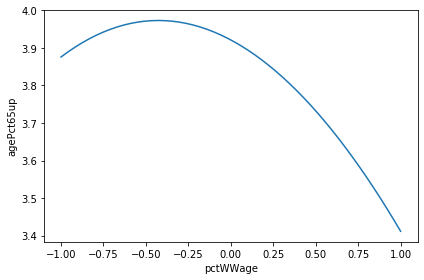

In [56]:
Xs = []
x = Xtrain[0]
xs = np.linspace(-1,1,50)
for e in xs:
    x[12] = e
    Xs.append(x.copy())
Xs = np.array(Xs)
plt.xlabel(df.columns[idx_use][12])
plt.ylabel(df.columns[idx_predict][-2])
plt.plot(xs, predict(Xs, A, b, C, d, Areg, breg)[0][:,0])
plt.tight_layout()
plt.savefig("figs/feature_effect.pdf")
plt.show()